# Assignment 4

#### In this assignment, we will conclude our analysis of whether the stop and frisk policy was racially discriminatory, but from a very different angle than our previous mapping analysis. We will rely heavily on logistic regression and regularized regression, as discussed in class. 

# Data processing (5 points)

First we need to do some data processing for consistency with previous of analysis of stop_and_frisk data. Load in the data "sqf_sample" and filter for stops between 2008 and 2012 (including both 2008 and 2012 in your sample). Filter for stops of white, Black, and Hispanic pedestrians using the suspect_race column. (5 points)


In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

In [2]:
df = pd.read_csv("sqf_sample.csv")
df.shape

(408615, 89)

In [3]:
df = df[(df.year >= 2008) & (df.year <= 2012)]
df.shape

(293278, 89)

In [4]:
df.suspect_race.unique()

array(['black', 'hispanic', 'asian', 'white', nan, 'other',
       'native american'], dtype=object)

In [5]:
keep_races = ['white', 'black', 'hispanic']

df = df[df.suspect_race.isin(keep_races)]
df.shape

(273235, 89)

## Using regression to analyze the frisk decision. (30 points)

We will start by testing for racial discrimination in the decision to conduct a frisk after a stop: ie, whether Black and Hispanic pedestrians are more likely to be frisked (patted down for weapons) after they are stopped, controlling for other factors.

a. Using statsmodels, perform a logistic regression, using `frisked` as the dependent variable and `suspect_race` as the independent variable, to assess how the probability of being frisked after a stop varies by race. Write a few sentences interpreting the results, making sure to answer the following questions: which value of suspect_race is omitted from the regression coefficients? Which race groups are most likely to be frisked after being stopped? How do you interpret the magnitude and sign of the coefficients? How do you interpret their statistical significance and confidence intervals? (5 points)

______

First, we will apply dummy encoding to the `suspect_race` columns.

In [6]:
log_reg = smf.logit(formula="frisked ~ suspect_race", data=df).fit()

Optimization terminated successfully.
         Current function value: 0.681731
         Iterations 4


In [7]:
log_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                frisked   No. Observations:               273235
Model:                          Logit   Df Residuals:                   273232
Method:                           MLE   Df Model:                            2
Date:                Tue, 09 Nov 2021   Pseudo R-squ.:                0.005119
Time:                        18:41:40   Log-Likelihood:            -1.8627e+05
converged:                       True   LL-Null:                   -1.8723e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.3005      0.005     58.114      0.000       0.290       0.311
suspect_race[T.hispanic]     0.0248      0.008      2.942      0.003       0.008       0.041
suspect_race[T.white]       -0.5447      0.013    -41.487      0.000      -0.570      -0.519
============================================================================================
"""

Black is omitted from the coefficients due to being categorically encoded as `[T.hispanic=0, T.white=0]`, and the intercept of the function can be used for interpreting the likelihood of blacks being stopped and frisked. The intercept is positive, and the hispanic coefficient is just above 0. This means that that these races have a similar, higher likelihood of being frisked after a stop. The coefficient for `white` on the other hand is negative; this goes to show that being white leads to a lower chance of a frisk taking place. A note on interpretation of the magnitude of these values: we can say that a value of e.g. 0.3 (for black) indicates that a a black suspect will have 0.3 _log odds ratio of being frisked_. I.e. this would be a exp(0.3) = 1.35 --> 35% probability of a frisk taking place. 

The p-values range between 0 and 0.003, which means that the results are highly significant for all suspect races (less than 0.05), and
the coefficients are all within the 95% confidence interval, which means that we can have high confidence in the model parameters.

b. Now perform a linear regression instead of a logistic regression using the same formula. How is the interpretation of the coefficients similar or different in the two regressions? What are the advantages of each? (5 points)

In [8]:
lr = smf.ols(formula = "frisked ~ C(suspect_race)", data=df)
result = lr.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                frisked   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     974.1
Date:                Tue, 09 Nov 2021   Prob (F-statistic):               0.00
Time:                        18:41:41   Log-Likelihood:            -1.9517e+05
No. Observations:              273235   AIC:                         3.903e+05
Df Residuals:                  273232   BIC:                         3.904e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       0.5746      0.001    454.716      0.000       0.572       0.577
C(suspect_race)[T.hispanic]     0.0061      0.002      2.941      0.003       0.002       0.010
C(suspect_race)[T.white]       -0.1353      0.003    -42.037      0.000      -0.142      -0.129
==============================================================================
Omnibus:                   987617.498   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            44329.166
Skew:                          -0.254   Prob(JB):                         0.00
Kurtosis:                       1.093   Cond. No.                         3.79
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Using linear regression, the interpretation of the coefficients is significantly different when compared to logistic regression. The coefficients now indicate whether there is a correlation between the suspect race and a stop and frisk. Once again, the intercept can be interpreted as a suspect's race being black. We notice that the output is high (~0.57) for hispanic and black suspects, indicating a strong correlation. A notable difference, is that there is also a correlation between `suspect_race_white` and a stop and frisk taking place. The key difference is that _all_ races are associated with some rate of frisks taking place. The rate at which people with race `white` are frisked, however, is lower than the case for `black` or `hispanic`. The intercept and coefficients for the three races, in this case, simply represent the mean rate at which frisks take place for each race. 

The logistic regression model is more usesful in use-cases where we are interested in predicting the log likelihood of a stop and frisk given a set of features, whereas the linear regression model can be used to determine relative rates of stop and frisks. The coefficients of the linear regression are arguably more interpretable since we do not need to interpret them in terms of logarithmic odds.

c. The regression using only race as an independent variable is a good starting point, but it does not control for any other variables. What other variables do you think are important to control for, and why?  (3 points)

It would be a good idea to control for variables that give insight into the police officer's decision and context when deciding to stop and frisk:
- Location because the demographics or crime rate in a neighborhood might influence police officers' rate of stop and frisks
- The suspect's gender and age because it might influence the police officer's propensity to do a stop and frisk if they intend to target certain demographics
- Reason for stopping a suspect because certain reasons may indicate a higher probability of possession of weapons
- Time of day because different types of people may be on the street at different times of day

d. Run a logistic regression where you control for both race and for the "precinct" variable, which encodes the police precinct in which the stop occurred. Make sure to control for precinct as a categorical, not a numerical, variable, by writing it as C(precinct) in the regression formula - why is this important to do?

How do the race coefficients change, and what does that mean? How does the interpretation of this regression differ from the regression in which you only control for race? Make one argument in favor of reporting results controlling for location, and one argument against it. (5 points)

In [9]:
import statsmodels.formula.api as smf

model = smf.logit(formula='frisked ~ suspect_race + C(precinct)', data=df)
result = model.fit()

result.summary()

Optimization terminated successfully.
         Current function value: 0.661055
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                frisked   No. Observations:               273235
Model:                          Logit   Df Residuals:                   273157
Method:                           MLE   Df Model:                           77
Date:                Tue, 09 Nov 2021   Pseudo R-squ.:                 0.03529
Time:                        18:41:46   Log-Likelihood:            -1.8062e+05
converged:                       True   LL-Null:                   -1.8723e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -0.0707      0.055     -1.285      0.199      -0.179       0.037
suspect_race[T.hispanic]    -0.1421      0.010    -14.301      0.000      -0.162      -0.123
suspect_race[T.white]       -0.4376      0.015    -28.354      0.000      -0.468      -0.407
C(precinct)[T.5.0]           0.1671      0.080      2.098      0.036       0.011       0.323
C(precinct)[T.6.0]           0.0652      0.075      0.868      0.386      -0.082       0.213
C(precinct)[T.7.0]           0.6852      0.074      9.252      0.000       0.540       0.830
C(precinct)[T.9.0]           0.1880      0.069      2.744      0.006       0.054       0.322
C(precinct)[T.10.0]          0.1072      0.076      1.406      0.160      -0.042       0.257
C(precinct)[T.13.0]         -0.2656      0.071     -3.749      0.000      -0.404      -0.127
C(precinct)[T.14.0]         -0.3892      0.063     -6.224      0.000      -0.512      -0.267
C(precinct)[T.17.0]         -0.4877      0.094     -5.186      0.000      -0.672      -0.303
C(precinct)[T.18.0]         -0.5383      0.078     -6.904      0.000      -0.691      -0.385
C(precinct)[T.19.0]         -0.2010      0.071     -2.828      0.005      -0.340      -0.062
C(precinct)[T.20.0]         -0.5269      0.075     -7.020      0.000      -0.674      -0.380
C(precinct)[T.22.0]         -0.5952      0.121     -4.915      0.000      -0.833      -0.358
C(precinct)[T.23.0]          0.2312      0.060      3.865      0.000       0.114       0.348
C(precinct)[T.24.0]         -0.1346      0.072     -1.881      0.060      -0.275       0.006
C(precinct)[T.25.0]          0.3702      0.063      5.857      0.000       0.246       0.494
C(precinct)[T.26.0]          0.4796      0.070      6.837      0.000       0.342       0.617
C(precinct)[T.28.0]          0.1113      0.064      1.732      0.083      -0.015       0.237
C(precinct)[T.30.0]          0.3258      0.067      4.854      0.000       0.194       0.457
C(precinct)[T.32.0]          1.0741      0.063     17.185      0.000       0.952       1.197
C(precinct)[T.33.0]          0.5380      0.068      7.862      0.000       0.404       0.672
C(precinct)[T.34.0]          0.4267      0.064      6.670      0.000       0.301       0.552
C(precinct)[T.40.0]          0.6442      0.060     10.768      0.000       0.527       0.761
C(precinct)[T.41.0]          0.6045      0.064      9.444      0.000       0.479       0.730
C(precinct)[T.42.0]          0.9483      0.063     14.974      0.000       0.824       1.072
C(precinct)[T.43.0]          0.4439      0.061      7.259      0.000       0.324       0.564
C(precinct)[T.44.0]          1.4285      0.063     22.696      0.000       1.305       1.552
C(precinct)[T.45.0]          0.0294      0.071      0.414      0.679      -0.110       0.168
C(precinct)[T.46.0]          1.3561      0.065     20.821      0.000       1.228       1.484
C(precinct)[T.47.0]          0.5585      0.064      8.777      0.000       0.43

We encode precinct as a categorical feature because we would like to encode each precinct as a distinct value. By controlling for precinct we can determine whether the stop and frisks are focused on certain precincts, for example areas with more blacks.

By controlling for precinct, we note that the intercept and suspect race coefficients reduce significantly to negative values, while precinct coefficients are positive. This indicates that whether a stop and frisk occurs is more dependent on the precinct than the suspect's race. The coefficient for white suspects is still much smaller, which suggests that their likelihood of being stopped is small regardless of the location.

**In favour of reporting results controlling for location:** we learn which precincts are more likely to do stop and frisks, which could help us locate bad practices in the police force.  
**Against:** Without investigating the race of the inhabitants in each precinct, we might not be able to tell that racial discrimination is prevalent. The coefficients are less interpretable to determine whether there is racial discrimination.

e. In a few sentences, explain why it is a BAD idea, conceptually, to control for the following variables if we are trying to assess whether the police racially discriminate in whom they frisk after a stop: a) "found.weapon", which encodes whether the frisk found a weapon, and b) "suspect.eye" and "suspect.hair", which encode the suspect's eye and hair color. (4 points)

- It is a bad idea to control for whether a weapon was found after the stop because it does not assess why the police officer chose to stop and frisk a suspect in the first place
- It's a bad idea to control for a suspect's eye and hair color because it correlates strongly with race, and if we control for them we will shift the weight of the suspect's race variable to other variables. This might underestimate the severity of the racial discrimination

For the purpose of figuring out whether police are racially discriminating against subjects we should control for other factors that might explain why or how the police are racially discriminating against suspects (such as the reason for a stop and frisk or the location).

f. In a few sentences, explain the problem of omitted variable bias in this analysis, and how it would undermine the conclusions. (4 points)

Omitted variable bias could bias the results of the analysis towards the variables we have at hand, while leaving out underlying explanations that more accurately describe the reasons for the stop and frisks and whether it is racially discriminating. For example, if we do not control by any variables and simply conclude that police stop and frisks are racially discriminatory based on the results in a), it would be trivial to undermine our conclusions by arguing that stop and frisks are justified in targeting black suspects because they commit more a higher rate of dangerous crimes. By controlling for an omitted variable such as crimes comitted by a race we can pre-emptively strengthen the conclusion and explain that the correlation is caused by racial discrimination.

g. In a few sentences, explain why only examining whether someone is frisked after a stop might fail to provide a full picture of discrimination in the stop and frisk policy. (4 points)

If we simply examine whether someone is frisked after a stop, we might fail to uncover discriminatory practices in the police forces' decision to target certain suspects. Considering the reason and context for a stop and frisk is important to paint a full picture of the situation. As an example, by considering the location of a stop and frisk, it might uncover that police are disproportionately targeting a neighborhood with certain demographics.  

## Outcome analysis using regularized regression (65 points)

Because of the issues with omitted variables in analyses like the one above, *outcome* tests are often used: these look not at the rate at which a decision is made (like the decision to frisk), but at the outcome of the decision (for example, if the frisk is conducted to find a weapon, does it actually find one?) Now we will use an outcome-style analysis. Specifically, we will fit a machine learning model to predict the probability that each stop which was conducted on suspicion the pedestrian possessed a weapon actually finds a weapon. Stops which are very unlikely to find a weapon arguably violate the Fourth Amendment, which prohibits unreasonable searches; if such stops disproportionately occur of certain race groups, the policy may violate the Fourteenth Amendment, which prohibits racial discrimination. 

a. In this portion of this analysis, you will be using a smaller version of the data to speed up model fitting. Load in "small_sqf_sample". As before, we need to do some data processing for consistency with previous of analysis of this data. Load in the data and filter for stops between 2008 and 2012 (including both 2008 and 2012); filter for stops of white, Black, and Hispanic pedestrians using the suspect_race column; and filter for stops conducted on suspicion of criminal posession of a weapon (ie, suspected_crime == 'cpw'). (5 points)

In [10]:
df_small = pd.read_csv("small_sqf_sample-2.csv")
df_small.shape

(204308, 89)

In [11]:
df_small = df_small[(df_small.year >= 2008) & (df_small.year <= 2012)]
df_small.shape

(146520, 89)

In [12]:
df_small = df_small[df_small.suspect_race.isin(keep_races)]
df_small.shape

(136357, 89)

In [13]:
df_small = df_small[df_small.suspected_crime == 'cpw']
df_small.shape

(36271, 89)


b. We will be fitting the regression model 

`found_weapon ~ C(precinct) * C(suspect_race) + C(location_housing) + C(year) + suspect_age + suspect_height + suspect_weight + suspect_sex + ADDITIONAL_CIRCUMSTANCE_COLUMNS` 

where ADDITIONAL_CIRCUMSTANCE_COLUMNS are any columns that begin with "stopped_bc" or "additional_" besides "additional_other" and "stopped_bc_other". You can get these columns by running

`ADDITIONAL_CIRCUMSTANCE_COLUMNS = [a for a in d.columns if ('stopped_bc' in a or 'additional_' in a) and a not in (['additional_other', 'stopped_bc_other'])]`

You should have 18 additional columns. These columns provide more information about the circumstances of the stop, and we include them for consistency with the original analysis and because they turn out to be important for predictive performance. 

Drop any rows with missing values in any of the variables you need. 

Now, we need to put the data into a format which sklearn can use later - ie, numpy arrays. Do this with "patsy" library and the "dmatrix" function. You can call dmatrix as follows:

`sqf_X = patsy.dmatrix('C(precinct) * C(suspect_race) + C(location_housing) + C(year) + suspect_age + suspect_height + suspect_weight + suspect_sex +' + '+'.join(ADDITIONAL_CIRCUMSTANCE_COLUMNS),sqf_data, return_type='dataframe')`

and it will return a dataframe on which you can fit a regression model. The first argument to dmatrix is the formula that you want to use to make the dataframe; the second argument gives patsy the data you want to use; return_type='dataframe' ensures that you get a dataframe, not a patsy object which is hard to use.

Look at the output of dmatrix and explain what the columns mean. Why can't we just pass the columns from the original dataframe directly into the sklearn function? (8 points)


In [14]:
ADDITIONAL_CIRCUMSTANCE_COLUMNS = [
    a for a in df_small.columns if ('stopped_bc' in a or 'additional_' in a) and a not in (['additional_other', 'stopped_bc_other'])
]

len(ADDITIONAL_CIRCUMSTANCE_COLUMNS)

18

In [15]:
ADDITIONAL_CIRCUMSTANCE_COLUMNS

['stopped_bc_object',
 'stopped_bc_desc',
 'stopped_bc_casing',
 'stopped_bc_lookout',
 'stopped_bc_clothing',
 'stopped_bc_drugs',
 'stopped_bc_furtive',
 'stopped_bc_violent',
 'stopped_bc_bulge',
 'additional_report',
 'additional_investigation',
 'additional_proximity',
 'additional_evasive',
 'additional_associating',
 'additional_direction',
 'additional_highcrime',
 'additional_time',
 'additional_sights']

In [16]:
df_small.shape

(36271, 89)

In [17]:
ALL_COLUMNS = ADDITIONAL_CIRCUMSTANCE_COLUMNS + [
    'precinct',
    'found_weapon',
    'suspect_race',
    'location_housing',
    'year',
    'suspect_age',
    'suspect_height',
    'suspect_weight',
    'suspect_sex',
]

df_all = df_small[ALL_COLUMNS]
df_all = df_all.dropna()
df_all.shape

(36056, 27)

In [18]:
df_all.found_weapon

0         False
7         False
17        False
20        False
23        False
          ...  
204287    False
204289    False
204291    False
204293    False
204303    False
Name: found_weapon, Length: 36056, dtype: bool

In [19]:
sqf_X = patsy.dmatrix(
    'C(precinct) * C(suspect_race) + C(location_housing) + C(year) + suspect_age + suspect_height + suspect_weight + suspect_sex +' + 
    '+'.join(ADDITIONAL_CIRCUMSTANCE_COLUMNS
), df_all, return_type='dataframe')

In [20]:
sqf_X.columns

Index(['Intercept', 'C(precinct)[T.5.0]', 'C(precinct)[T.6.0]',
       'C(precinct)[T.7.0]', 'C(precinct)[T.9.0]', 'C(precinct)[T.10.0]',
       'C(precinct)[T.13.0]', 'C(precinct)[T.14.0]', 'C(precinct)[T.17.0]',
       'C(precinct)[T.18.0]',
       ...
       'C(precinct)[T.112.0]:C(suspect_race)[T.white]',
       'C(precinct)[T.113.0]:C(suspect_race)[T.white]',
       'C(precinct)[T.114.0]:C(suspect_race)[T.white]',
       'C(precinct)[T.115.0]:C(suspect_race)[T.white]',
       'C(precinct)[T.120.0]:C(suspect_race)[T.white]',
       'C(precinct)[T.122.0]:C(suspect_race)[T.white]',
       'C(precinct)[T.123.0]:C(suspect_race)[T.white]', 'suspect_age',
       'suspect_height', 'suspect_weight'],
      dtype='object', length=256)

In `sqf_X`, we notice that categorical columns have been dummy encoded, such that they are numeric. In this way, they can be interpreted by the logistic regression model. If we were to just feed the original columns to the `sklearn` model, this would not be the case. 

c. As discussed in class, when fitting machine learning models, you should always divide the dataset into a train, val, and test set. Randomly divide the filtered, processed data into three pieces - the train set (60%), the val set (20%) and the test set (20%). (5 points)

In [21]:
sqf_X_train = sqf_X.sample(frac=0.6)
sqf_X_train.shape

(21634, 256)

In [22]:
train_indices = sqf_X_train.index
sqf_X_left = sqf_X[~sqf_X.index.isin(train_indices)]

sqf_X_val = sqf_X_left.sample(frac=0.5)
sqf_X_test = sqf_X_left[~sqf_X_left.index.isin(sqf_X_val.index)]

val_indices = sqf_X_val.index
test_indices = sqf_X_test.index

(sqf_X_train.shape, sqf_X_val.shape, sqf_X_test.shape)

((21634, 256), (7211, 256), (7211, 256))

In [23]:
y_test_race = df_all.suspect_race.loc[test_indices]
y_test_race.head()

0         black
42     hispanic
61     hispanic
83        black
101       black
Name: suspect_race, dtype: object

In [24]:
y_train = df_all.found_weapon.loc[train_indices]
y_train.head()

78630     False
140970    False
172829    False
7830      False
104352    False
Name: found_weapon, dtype: bool

In [25]:
y_val = df_all.found_weapon.loc[val_indices]
y_test = df_all.found_weapon.loc[test_indices]

(y_val.shape, y_test.shape)

((7211,), (7211,))

d. We will be training a regularized logistic regression model to predict the outcome. When using many machine learning models, including regularized logistic regression, it is important to preprocess the input features so they are all on the same scale, for reasons discussed in class. In this case, we will take each column in the input data, subtract its mean, and divide by its standard deviation. This makes it so each column of the data has mean 0 and standard deviation 1. 

When scaling the data, it is important to compute the scaling using only the train set, as shown in class. The reason is that we are pretending that the train data is all we have access to to fit our model fitting pipeline, so we cannot "peek" at the validation or test sets to generate our scaling. Use sklearn's StandardScaler (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) to fit a scaling transform on the train set and transform the train set (you can use the fit_transform method on the train set).Then apply the fitted StandardScaler model to the validation and test sets as well (using the transform --- not the fit --- method). (Look at the notebook we went through in class on regularization and lasso if you are confused.) The transformed datasets are the final datasets you will feed into your logistic regression model. (5 points)

In [26]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(sqf_X_train)

sqf_X_train = scaler.transform(sqf_X_train)
sqf_X_val = scaler.transform(sqf_X_val)
sqf_X_test = scaler.transform(sqf_X_test)

e. Uisng sklearn.linear_model.LogisticRegression, fit a model on the train set to predict found_weapon. Set the "penalty" argument to "none" so that the model will not use any regularization; this corresponds to fitting a regular logistic regression model. If you get a `ConvergenceWarning`, increase the number of iterations using the `max_iter` argument; this means the model optimization needs more iterations to converge. (Look at the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) if you are uncertain which arguments to use!)

A standard measure of predictive performance for binary outcome variables like found_weapon is AUC. Higher values of AUC are better; an AUC of 1 means that the model is perfectly predicting the outcome; an AUC of 0.5 means that it is predicting it only as well as random chance. Report the AUC of the fitted model (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) on both the train and validation sets. What is the problem with using accuracy as a metric for this task? How does the train set AUC differ from the validation AUC, and does this make sense? (7 points)

In [27]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(penalty='none', max_iter=2000)

In [28]:
clf.fit(sqf_X_train, y_train)

LogisticRegression(max_iter=2000, penalty='none')

In [29]:
from sklearn.metrics import roc_auc_score

auc_train = roc_auc_score(y_train, clf.predict_proba(sqf_X_train)[:, 1])
auc_val = roc_auc_score(y_val, clf.predict_proba(sqf_X_val)[:, 1])

print("The AUC of the training set is", round(auc_train, 3))
print("The AUC of the val set is", round(auc_val, 3))

The AUC of the training set is 0.833
The AUC of the val set is 0.727


In [30]:
y_train.value_counts(normalize=True)

False    0.965517
True     0.034483
Name: found_weapon, dtype: float64

- **What is the problem of using accuracy as a metric for this task?** The prediction label (`found_weapon`) is heavily imbalanced: in only 3% of cases, a weapon is found. A model, which always predicts `False`, would thus be able to achieve an accuracy of 97%. The AUC metric, instead, accounts for the fact that the labels are imbalanced, and thus gives a better metric of success of the model.
- **How does the training set AUC differ from the validation AUC, and does this make sense?** The training AUC is higher than the validation AUC, by about 0.07. This is to be expected. After all, the model has been trained on the training set, and thus should be better at predicting the training samples. The model has never seen the validation set, as a result of which we expect the model to perform (slightly) worse here. 

f. Our logistic regression model is not using any regularization and appears to be overfitting. We will try to use regularization to reduce overfitting. You will be fitting an L1-penalized logistic regression model using code that looks something like

`LogisticRegression(C=sparsity_param, penalty='l1', solver='liblinear')`

(the "l1" specifies that we're using an L1 penalty, as discussed in class; the "liblinear" solver is an optimizer that works with the L1 penalty. See the logistic regression documentation for more details.) 

Increase and decrease the amount of regularization using different values of the C parameter, searching logarithmically over at least 20 values in the range from 1e-2 to 1. (Note: we do not recommend defining a variable named "C" in your code, because this may cause weird patsy issues, since patsy also uses "C". Give the variable another name. Sorry! I complained to the patsy people.) 

Print out the train set, val set, and test set AUC for each value of of the regularization parameter. Make a plot where the x-axis is the regularization parameter and the y-axis is AUC, with one line for train AUC, one line for val AUC, and one line for test AUC (use plt.semilogx to plot the lines so the x-axis will be logarithmic, making it easier to see the plot). Comment on the trends. Do you see evidence of overfitting? Explain. For the rest of this assignment, use the model with the highest AUC on the validation set. (10 points)

In a full analysis, it would make sense to play with other aspects of the model as well: for example, you could try using other forms of regularization (like L1 vs L2) or other classification algorithms besides logistic regression. The basic pattern, though, would be the same: fit the model on the train set, choose models on the val set, and once you've chosen your best model, assess your results (once!) on the test set.

In [31]:
C_values = [
    1e-2,
    2e-2,
    3e-2,
    4e-2,
    5e-2,
    6e-2,
    7e-2,
    8e-2,
    9e-2,
    1e-1,
    2e-1,
    3e-1,
    4e-1,
    5e-1,
    6e-1,
    7e-1,
    8e-1,
    9e-1,
    1
]

In [32]:
train_aucs = []
val_aucs = []
test_aucs = []

for C_value in C_values:
    clf_l1 = LogisticRegression(C=C_value, penalty='l1', solver='liblinear', max_iter=2000)
    clf_l1.fit(sqf_X_train, y_train)
    auc_train = roc_auc_score(y_train, clf_l1.predict_proba(sqf_X_train)[:, 1])
    auc_val = roc_auc_score(y_val, clf_l1.predict_proba(sqf_X_val)[:, 1])
    auc_test = roc_auc_score(y_test, clf_l1.predict_proba(sqf_X_test)[:, 1])
    train_aucs.append(auc_train)
    val_aucs.append(auc_val)
    test_aucs.append(auc_test)
    

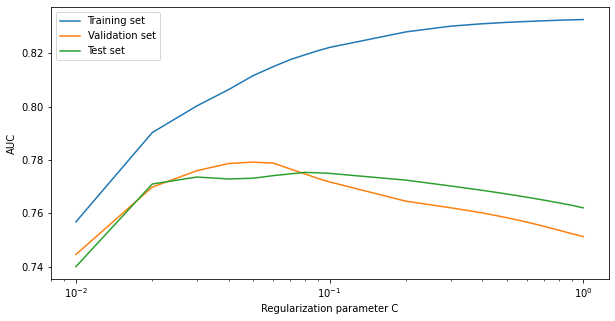

In [33]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))
ax.semilogx(C_values, train_aucs, label='Training set')
ax.semilogx(C_values, val_aucs, label='Validation set')
ax.semilogx(C_values, test_aucs, label='Test set')
ax.set_xlabel("Regularization parameter C")
ax.set_ylabel("AUC")
ax.legend()

**Analysis**: we notice that, the higher the value of the `C` parameter, the higher the AUC value for the training set. At the same time, this behaviour does not hold for the validation and test set. Initially, we see their AUC value increase, but as some point (around `C=0.1`), their AUC decreases. This indicates that, for values of `C` higher than 0.1, overfitting does indeed take place. 

In [43]:
val_aucs

[0.7445940407175897,
 0.7698364185719078,
 0.7759853392108782,
 0.7786769500077958,
 0.7791833803442426,
 0.7788148526125308,
 0.7766243568482375,
 0.7747651816888964,
 0.7730719621266885,
 0.7717726656366789,
 0.7645574359919303,
 0.7620905444288528,
 0.7601699479808933,
 0.7583727846994844,
 0.7567238593357996,
 0.755143442332497,
 0.7537000420499592,
 0.7524113761675951,
 0.7512922094182458]

In [47]:
[i for i,j in enumerate(val_aucs) if j == max_val][0]

4

In [48]:
max_val = max(val_aucs)
argmax = [i for i,j in enumerate(val_aucs) if j == max_val][0]
best_C = C_values[int(argmax)]

best_C

0.05

g. Assess model *calibration* on the test set. This checks whether the model's predicted probabilities line up with the true probabilities, and is important to assess here because we will be analyzing the model's predicted probabilities. To assess calibration, take the 10% of rows of the test set with the highest model predictions and compare the mean model predicted probability (ie, the output of `predict_proba`) to the actual mean of the outcome variable. Repeat for the next 10% of rows, and for all 10% groups. Make a plot comparing the model predicted probabilities on each 10% group to the actual outcomes (mean predicted probability on the x-axis and mean actual outcome on the y-axis). You should end up with a plot with 10 points, one for each 10% group. Plot the line y=x so you can see how well the predicted probabilities line up with the actual probabilities - ideally, your points will lie on the line or close to it. (10 points)

Calibration is an issue for many machine learning models, including deep learning models, so this is always a good thing to check. In a full analysis, it would make sense to check calibration (and AUC) for subgroups as well (eg, each race group).

In [49]:
clf_l1 = LogisticRegression(C=best_C, penalty='l1', solver='liblinear', max_iter=2000)
clf_l1.fit(sqf_X_train, y_train)

y_test_pred = pd.Series(clf_l1.predict_proba(sqf_X_test)[:, 1], index=y_test.index)
y_test_pred.name = "pred"
y_test_results = y_test.copy()

y_test_results = pd.concat([y_test_results, y_test_pred], axis=1)
y_test_results.head()


,found_weapon,pred
0,False,0.032528
42,False,0.016828
61,False,0.010441
83,False,0.024363
101,False,0.036032


In [50]:
y_test_results = y_test_results.sort_values(by='pred', ascending=False)
y_test_results.head()

,found_weapon,pred
142568,True,0.934061
166365,False,0.914787
196743,True,0.892607
17784,True,0.851492
30290,True,0.803609


In [51]:
share = round(y_test_results.shape[0] / 10)
start = 0

means = []
pred_probas = []

for i in range(10):
    times = i+1
    if i == 9:
        subset = y_test_results[start:]
    else:
        subset = y_test_results[start:share*times]
    pred_proba = subset.pred.mean()
    mean = subset.found_weapon.mean()
    means.append(mean)
    pred_probas.append(pred_proba)
    start+= share

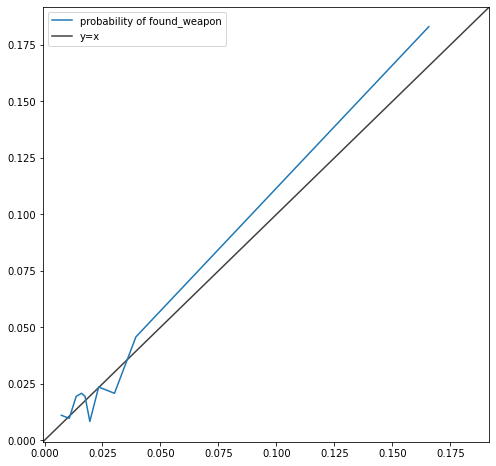

In [52]:
fig, ax = plt.subplots(figsize=(8,8))

ax.plot(pred_probas, means, label="probability of found_weapon")

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0, label="y=x")
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.legend()

h. Using the test set, compute the fraction of observations which have lower than a 2% model-predicted probability of finding a weapon for Black, Hispanic, and white pedestrians. Stops below this threshold are extremely unlikely to have resulted in finding a weapon, arguably violating the Fourth Amendment. Repeat this for 20 thresholds evenly spaced between 1% and 5%. Make a graph where the x-axis is the threshold, and the y-axis is the fraction of stops falling below that threshold, with one line for each race group. Explain what you observe. Do you think this graph provides evidence for Fourteenth Amendment violations (racial discrimination)? (10 points)

In [53]:
threshold = 0.02

total_black_stops = y_test_race[y_test_race == 'black'].shape[0]
total_white_stops = y_test_race[y_test_race == 'white'].shape[0]
total_hispanic_stops = y_test_race[y_test_race == 'hispanic'].shape[0]

sub_results = y_test_results[y_test_results.pred < threshold]
relevant_index = sub_results.index
relevant_race = df_all.loc[relevant_index, 'suspect_race']
total_black = relevant_race[relevant_race == 'black'].shape[0]
total_white = relevant_race[relevant_race == 'white'].shape[0]
total_hispanic = relevant_race[relevant_race == 'hispanic'].shape[0]

print("Black stops under 2% threshold", total_black / total_black_stops)
print("White stops under 2% threshold", total_white / total_white_stops)
print("Hispanic stops under 2% threhsold", total_hispanic / total_hispanic_stops)

Black stops under 2% threshold 0.6306928556011224
White stops under 2% threshold 0.15570934256055363
Hispanic stops under 2% threhsold 0.5024027959807776


In [54]:
steps = [(i/5 + 1)/100 for i in range(21)]
(min(steps), max(steps))

(0.01, 0.05)

In [55]:
total_black_stops = y_test_race[y_test_race == 'black'].shape[0]
total_white_stops = y_test_race[y_test_race == 'white'].shape[0]
total_hispanic_stops = y_test_race[y_test_race == 'hispanic'].shape[0]

black_stops = []
white_stops = []
hispanic_stops = []

for step in steps:
    sub_results = y_test_results[y_test_results.pred < step]
    relevant_index = sub_results.index
    relevant_race = df_all.loc[relevant_index, 'suspect_race']
    total_black = relevant_race[relevant_race == 'black'].shape[0]
    total_white = relevant_race[relevant_race == 'white'].shape[0]
    total_hispanic = relevant_race[relevant_race == 'hispanic'].shape[0]

    black_stops.append(total_black / total_black_stops)
    white_stops.append(total_white / total_white_stops)
    hispanic_stops.append(total_hispanic / total_hispanic_stops)

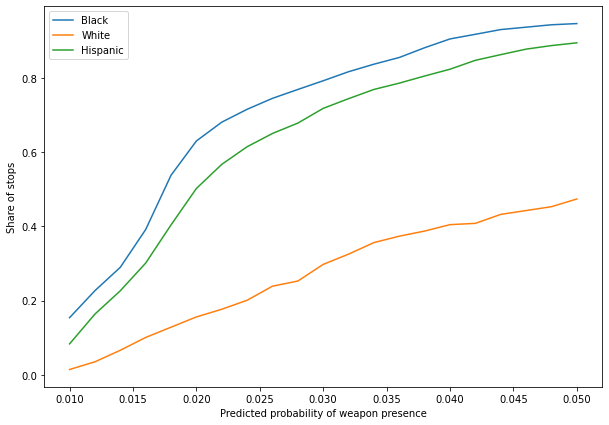

In [56]:
fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(steps, black_stops, label="Black")
ax.plot(steps, white_stops, label="White")
ax.plot(steps, hispanic_stops, label="Hispanic")

ax.set_xlabel("Predicted probability of weapon presence")
ax.set_ylabel("Share of stops")

ax.legend()

We notice that, for an equal predicted probability of weapon presence, white people are less likely to be stopped than black and hispanic people. Additionally, while the relationship between the variables for white people appears to be linear, we notice that, even for low values of predicted presence of a weapon, the rates of stops for black and hispanic people increase sharply. For comparison, according to our model 63% and 50% of stop and frisks had less than 2% probability of weapon presence for black and hispanic suspects compared to 16% for white suspects. 

Given that we have controlled for certain variables (such as location and sex), this suggests that the stops are racially discriminatory against blacks and hispanics and could be used as evidence for arguing that there is a Fourteenth Amendment violation by the NYPD because similarly situated suspects are disproportionately targeted in stop and frisks depending on their race.

i. The analysis you have performed in the second part of this assignment is very similar to the analysis in [this paper](https://5harad.com/papers/stop-and-frisk.pdf). Read the paper and write a few sentences about their main conclusions. (5 points)

Similar to our analysis, Goel et al. find that for 40% of stop and frisk cases conducted by NYPD between 2008 and 2012 there was less than 1% likelihood of finding a weapon, and in these "low hit rate contexts" blacks and Hispanics were disproportionately stopped. Furthermore, they find that a large proportion of these low threshold stops (regardless of race) occur in high-crime, predominantly minority areas. Beyond noting the racial disparity in stop and frisks, the authors demonstrate that by conducting only 6% of stops NYPD could recover the majority (50%) of weapons and mitigate racial disparities in who is stopped. They develop this model based on simple heuristics that could be easily implemented in the police force to inform their stop and frisk strategy.